<a href="https://colab.research.google.com/github/yoii18/KaggleModels/blob/main/DL_ImageClassification_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchvision import models

In [2]:
# Use CPU or GPU depensing on what is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Split the dataset.
1. Imported the dataset using the ImageFolder function of torchvision, <b>ImageFolder gives us the path of each individual image</b>
2. used train_test_split of sklearn to split the data into train and test data and train and test labels

Created an ImageLoader class with the following functions:
1. __ __init__ __: takes dataset and transform as inputs. Constructor
2. __ __len__ __: takes no inputs. Returns length of dataset
3. __ __getitem__ __: takes item as input, item is 1 particular image number from the dataset so dataset[item][0] returns an image while dataset[item][1] returns the label associated with that particular image. Returns transformed image and class label for that image
4. __checkChannel__: uses getbands() to see if image is in RGB band, if it is then the image is added to the datasetRGB list and this list is returned.

<b>But why do we need this class?</b><br>
We need this class to create a custom dataset.<br>
Custom Dataset class must execute 3 functions that we mentioned above, checkChannel function is an extra function that we implemented

<b>What exactly are we doing with this class?</b>
first we run the __ __init__ __ function once to instantiate the Dataset object (torch.utils.data.Dataset), in this function we basically use our checkChannel to get only the RGB images in our dataset and then we initialize the transform as well if it exists

then we run our __ __len__ __ function which simply returns the length of dataset

then we run the __ __getitem__ __ function which loads and returns a sample from the dataset at given index `item`. We need to convert these images to tensors, in the documentation of PyTorch they used the read_image function and os.path.join to accomplish this task but since ImageFolder gives us paths of individual images we simply use Image.open() to get the path of images at index `item` and then we get the classCategory of that particular image at that index. We then transform the image if the transform exists.

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html





In [3]:
from sklearn.model_selection import train_test_split
dataset = ImageFolder("/content/drive/MyDrive/Colab_Data/Cat_Dog/training_set")
train_data, test_data, train_label, test_label = train_test_split(dataset.imgs, dataset.targets, test_size = 0.2, random_state=42)

class ImageLoader(Dataset):
  def __init__(self, dataset, transform=None):
    self.dataset=self.checkChannel(dataset)
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, item):
    image = Image.open(self.dataset[item][0])
    classCategory = self.dataset[item][1]
    if self.transform:
      image = self.transform(image)

    return image, classCategory

  def checkChannel(self, dataset):
    datasetRGB = []
    for index in range(len(dataset)):
      if (Image.open(dataset[index][0]).getbands()==("R", "G", "B")):
        datasetRGB.append(dataset[index])
    return datasetRGB

In [15]:
dataset.targets[10]

0

We defined the train_transform and test_transform using transforms.Compose:
1. resize the image to (224,224)
2. convert the image to tensor, we can do this in the previous step as well by following the documentation and omiting this from our transform
3. normalize the images, we do this to make sure that the pixel values of our images are within a certain range which makes it easier for the model to learn patterns.

then we called our custom dataset creation class ImageLoader with train_data and train_transform and similarly did it to create the test counterparts as well

In [18]:
train_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)])
test_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)])

train_dataset = ImageLoader(train_data, train_transform)
test_dataset = ImageLoader(test_data, test_transform)

In [25]:
train_data[100][0]

'/content/drive/MyDrive/Colab_Data/Cat_Dog/training_set/dogs/dog.2575.jpg'

We use DataLoaders to prepare our custom datasets for training and testing
<br> torch.utils.data.Dataset retrives the information of our dataset and transforms it one sample at a time, but we cannot do this in training where we need to train and test using small batches, often shuffled. For this purpose we use the DataLoaders.

In [61]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

 Each iteration below returns a batch of train_features and train_labels (containing batch_size=62 features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])
Feature shape: torch.Size([3, 224, 224])


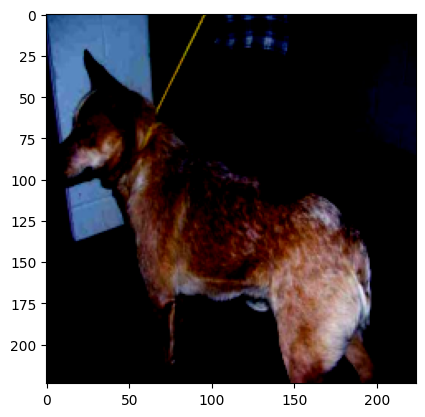

Label: 1


In [62]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].numpy().transpose((1,2,0))
label = train_labels[0]
print(f"Feature shape: {train_features[0].size()}")
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [63]:
model = models.resnet101(pretrained=True)

In [64]:
for param in model.parameters():
  param.req_grads=False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [65]:
num_ftrs

2048

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

def train(num_epoch, model):
  for epoch in range(0, num_epoch):
    losses = []
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader))

    for batch_idx, (data, targets) in loop:
      data = data.to(device=device)
      targets = targets.to(device=device)
      scores = model(data)

      loss = criterion(scores, targets)
      optimizer.zero_grad()
      losses.append(loss)
      loss.backward()
      optimizer.step()
      _, preds = torch.max(scores, 1)

      loop.set_description(f"Epoch {epoch+1}/{num_epoch} process: {int((batch_idx / len(train_loader)) * 100)}")
      loop.set_postfix(loss=loss.data.item())

      torch.save({
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  }, 'checkpoint_epoch_'+str(epoch)+'.pt')


def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for x,y in test_loader:
      x = x.to(device)
      y = y.to(device)
      output = model(x)
      _, predictions = torch.max(output, 1)
      correct += (predictions == y).sum().item()
      test_loss = criterion(output, y)
  test_loss /= len(test_loader.dataset)
  print("Average Loss: ", test_loss, "  Accuracy: ", correct, " / ",
  len(test_loader.dataset), "  ", int(correct / len(test_loader.dataset) * 100), "%")


In [78]:
if __name__ == '__main__':
  train(20, model)
  test()

Epoch 20/20 process: 99: 100%|██████████| 100/100 [04:56<00:00,  2.96s/it, loss=0.362]


Average Loss:  tensor(0.0003, device='cuda:0')   Accuracy:  1289  /  1600    80 %


In [79]:
import os
from PIL.Image import new as pil_img_new
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import time
import shutil
from pathlib import Path
import random
from tqdm import tqdm

In [80]:
checkpoint = torch.load("./checkpoint_epoch_18.pt")
model.load_state_dict(checkpoint["model_state_dict"])
print("----> Loading checkpoint")

----> Loading checkpoint


In [81]:
dataset = ImageFolder("/content/drive/MyDrive/Colab_Data/Cat_Dog/test_set",
                     transform=transforms.Compose([
                         transforms.Resize((224, 224)),
                         transforms.ToTensor(),
                         transforms.Normalize([0.5]*3, [0.5]*3)
                     ]))
print(dataset)
dataloader = DataLoader(dataset, batch_size=1, shuffle = True)
len(dataloader)

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /content/drive/MyDrive/Colab_Data/Cat_Dog/test_set
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


2000

In [82]:
def convert_image(tensor_image) -> np.array:
  array_image = tensor_image.cpu().numpy().squeeze(axis=0)
  array_image = array_image.transpose(1,2,0)
  array_image = array_image.clip(0,1)
  return array_image

In [83]:
def create_dir():
    path = os.getcwd() + "/Data"
    pathes = []
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)
    for dir_path in tqdm(["/Cats", "/Dogs"]):
        class_path = path+dir_path

        os.mkdir(class_path)
        pathes.append(class_path)
    return {0:pathes[0],
            1:pathes[1]}

In [84]:
def dir_random_show(classes: str, dir: int):
    for i in range(2):
        dir_path = classes[dir]
        filename = random.choice(os.listdir(dir_path))
        img_path = f"/{filename}"
        path = dir_path+img_path
        label = path.split("/")[-2]
        with Image.open(path) as img:
            fig =  plt.figure(figsize=(8,8))
            plt.imshow(img)
            plt.title(label)
            plt.show()

In [85]:
def make_classification():
    labels = {0:"Cat",
              1: "Dog"}

    with torch.no_grad():
        model.eval()

        for batch_idx, (data, targets) in tqdm(enumerate(dataloader)):

            data1, target1 = data.to(device), targets.to(device)
            output = model(data1)
            _, predicted = torch.max(output, 1)

            fig =  plt.figure(figsize=(8,8))
            plt.imshow(convert_image(data))
            plt.title(f"Predicted: {labels[predicted[0].item()]}")
            plt.show()
            if batch_idx >= 6:
                print("End classification")
                break

In [86]:
def dir_appends(classes):
    with torch.no_grad():
        model.eval()
        for batch_idx, sample in tqdm(enumerate(dataloader)):
            data, _ = sample
            data = data.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            path = classes[predicted[0].item()]
            Image.fromarray((convert_image(data)*255).astype('uint8'), mode="RGB").save(f'{path}/{batch_idx}.jpg')
            file = Path(f'{path}/{batch_idx}.jpg')
            file.touch(exist_ok=True)


0it [00:00, ?it/s]

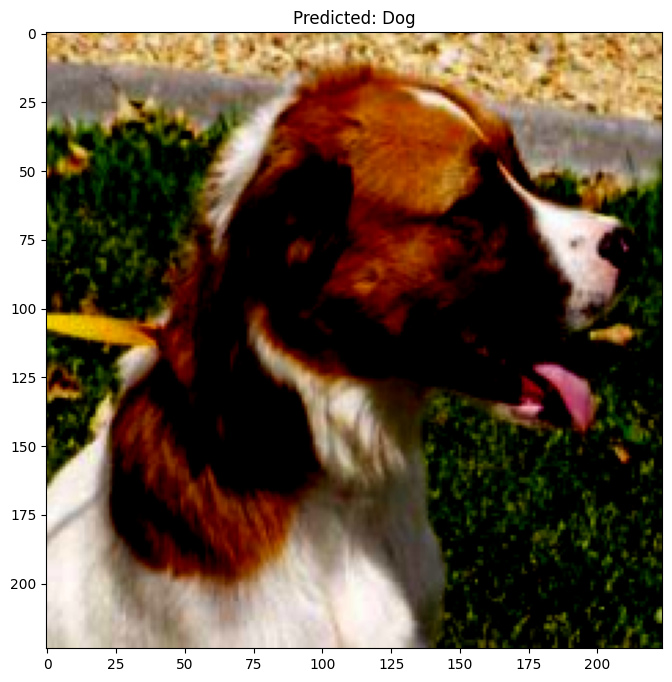

1it [00:01,  1.24s/it]

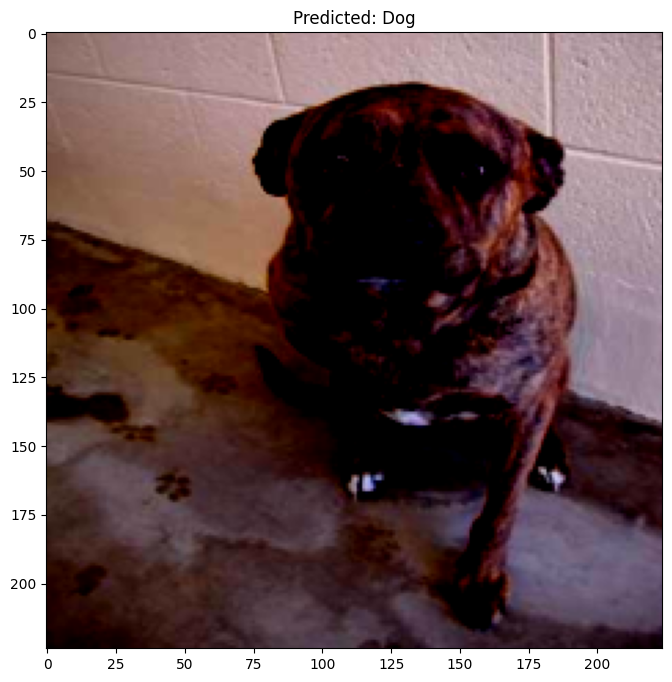

2it [00:02,  1.21s/it]

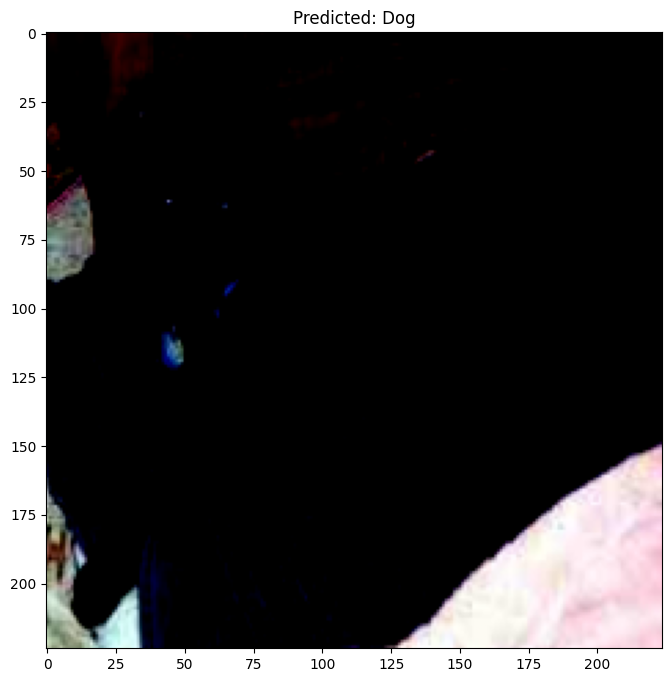

3it [00:03,  1.23s/it]

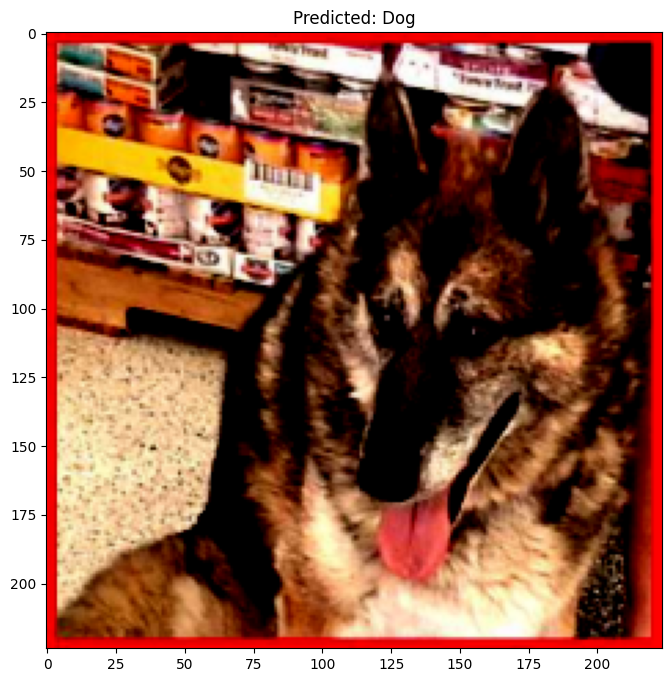

4it [00:05,  1.28s/it]

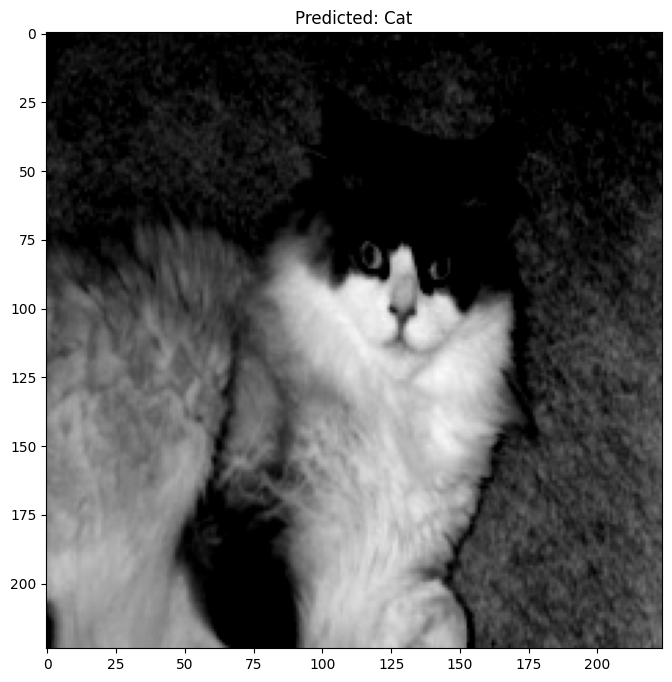

5it [00:06,  1.32s/it]

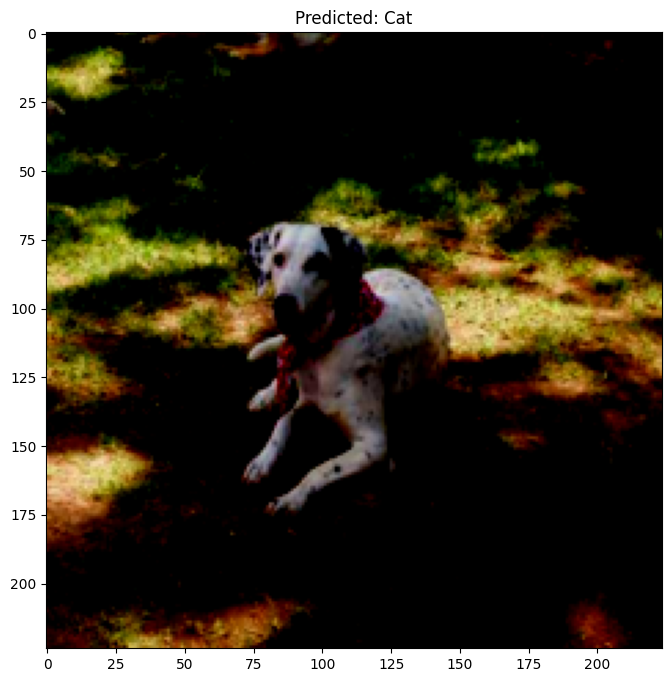

6it [00:07,  1.30s/it]

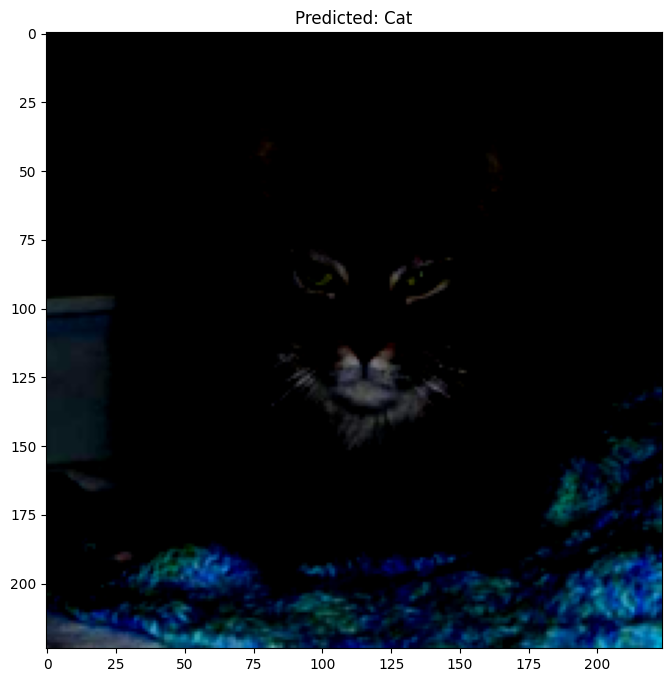

6it [00:08,  1.47s/it]

End classification


In [87]:
make_classification()